In [49]:
from pyspark import SparkContext
import datetime
from csv import reader
import pandas            as pd
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
%matplotlib inline
matplotlib.style.use('ggplot')

### Data Clean

In [50]:
sc = SparkContext()
# use dataclean.py from here to clean data
filepath    = r'./NYPD_Complaint_Data_Historic.csv'
df = sc.textFile(filepath).map(lambda l: reader([l]).__next__())

header = df.first() # csv header

df = df.filter(lambda line: line != header).cache() # filter out header

In [51]:
def transform(array):
    array[1] = datetime.datetime.strptime(array[1], '%m/%d/%Y')
    array[2] = datetime.datetime.strptime(array[2], '%H:%M:%S').time()
    return array

#replace year 1015
def replaceYear2015to2015(array):
    array[1] = array[1].replace('1015', '2015')
    return array

def replaceTime24to00(array):
    array[2] = array[2].replace('24:00:00', '00:00:00')
    return array

t = df \
    .filter(lambda array: array[1] != '' and array[2] != '') \
    .map(replaceYear2015to2015) \
    .map(replaceTime24to00) \
    .map(transform) \
    .filter(lambda array: (array[1].year >= 2006 and array[1].year <= 2015))

### Analysis

In [52]:
def timeMap(x):
    if x[2].hour >= 0 and x[2].hour < 6:
        return ('Midnight',1)
    elif x[2].hour >= 6 and x[2].hour < 12:
        return ('Morning', 1)
    elif x[2].hour >= 12 and x[2].hour < 18:
        return ('Afternoon', 1)
    else:
        return ('Evening', 1)


timeCount = t \
    .map(timeMap) \
    .reduceByKey(lambda x, y: x + y) \

In [53]:
time = timeCount.collect()
time

[('Afternoon', 1676800),
 ('Morning', 924952),
 ('Midnight', 850490),
 ('Evening', 1629512)]

In [54]:
timeLabel = np.array(time)[:,0]
count = np.array(time)[:,1]

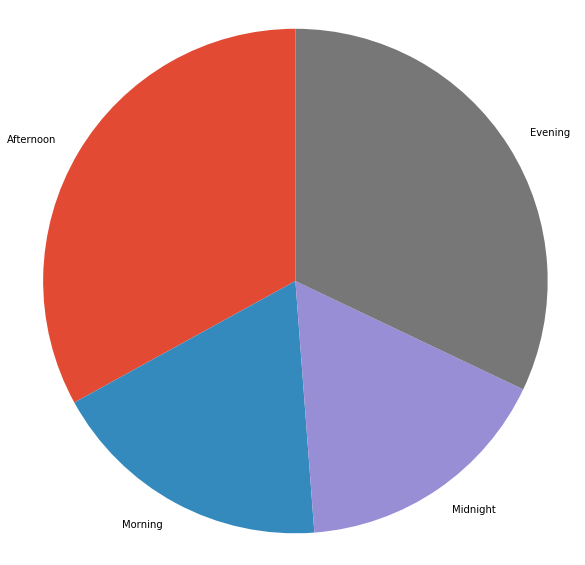

In [70]:
fig, ax = plt.subplots()
ax.pie(count, labels=timeLabel, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig.set_size_inches(10,10)

In [56]:
def timeCrimeMap(x):
    if x[2].hour >= 0 and x[2].hour < 6:
        return ('1 ' + x[11],1 / 850490)
    elif x[2].hour >= 6 and x[2].hour < 12:
        return ('2 ' + x[11], 1 / 924952)
    elif x[2].hour >= 12 and x[2].hour < 18:
        return ('3 ' + x[11], 1 / 1676800)
    else:
        return ('4 ' + x[11], 1 / 1629512)
    
timeCrimeCount = t \
    .map(timeCrimeMap) \
    .reduceByKey(lambda x, y: x + y) \
    .map(lambda x: (x[0].split(' ')[0], x[0].split(' ')[1], x[1]))

In [57]:
timeCrime = np.sort(np.array(timeCrimeCount.collect(), dtype=[('time', int), ('ctype', 'S15'), ('percent', float)]), order='time')
timeCrime
# draw this image on Excel

array([(1, b'FELONY',  0.34791356), (1, b'MISDEMEANOR',  0.57625134),
       (1, b'VIOLATION',  0.07583511), (2, b'FELONY',  0.31842842),
       (2, b'MISDEMEANOR',  0.53427854), (2, b'VIOLATION',  0.14729305),
       (3, b'FELONY',  0.2935365 ), (3, b'MISDEMEANOR',  0.5737494 ),
       (3, b'VIOLATION',  0.1327141 ), (4, b'FELONY',  0.2908294 ),
       (4, b'MISDEMEANOR',  0.59217729), (4, b'VIOLATION',  0.11699331)], 
      dtype=[('time', '<i8'), ('ctype', 'S15'), ('percent', '<f8')])

In [46]:
sc.stop()